Project Progress Report Title:

Team

Name (NetID): Expanded roles and current contributions.

Stephen Cox, ssj63. improved model progress and data handling

Shaz Momin, wzu2. Baseline model.

Prabesh Shrestha, hdw48. model analysis.

## Abstract

The goal of this project is to use historical U.S. Department of Agriculture (USDA) National Agricultural Statistics Service (NASS) census data to build a machine learning model that predicts county-level production per commodities for Texas farms.
Using data from the 2012, 2017, and 2022 agricultural censuses, we will develop baseline regression models and apply an improved neural network approach.
We also aim to interpret the model to understand how crop production can be predicted and how it can benefit farmers.


## Problem Statement

- Farmers in Texas are a very important part of our community. It is important to know what factors can effect the success of our farmers and their product since many people relay on Texas grown crops.

- What factors most deeply effect our farms success and can we predict if our farms will be succesful for the year.

- Benchmarks we will use are Mean Absolute Error, Root Mean Squared Error and R^2. Each of these scores we help us interpret different parts of the models accuracy/precision/recall since this is a regressive model

- The Data comes from US Department of Agriculture - National Agricultural Statistics Service census data which includes many different info points like: yield, land size and fertilizer... 

- Practical Interpretability, we hope to use this model to try and interpret correlations between farming factors and the production per commodities

- What we hope to achieve
    - Build a working NN regressor that predicts county-level production per commodities for Texas using 2012/2017/2022 data.
    - Beat simple baselines (mean and linear reg.) by at least a measurable margin (lower MAE/RMSE).
    - Produce interpretable model explainers (SHAP or partial dependence) showing the most influential

# EDA

### Expanded explanation, addressing all feedback and what has been learned about the dataset and the task since the project proposal.

Down below is the EDA on the cleaned dataset that we are using. We have discovered multiple issues with the dataset for our goal and have to shift according to our models. The primary issue with this dataset is that for are particular target, yield, many 
counties do not report yield. The issue in this is when pivoting the table by a key using pandas, the pivot drops most NaN columns or columns that would not be fully made. We pivoted our data by counties in Texas, there are only about 170 yield reports out of 762 county reports in the 3 years of census data that we are using. 

## Dataset

### NASS Quick Stats Data — Brief Description for EDA

The **USDA NASS Quick Stats** database is a large, publicly accessible repository of agricultural statistics collected across the United States. It provides **standardized survey and census measurements** for crop production, yields, acreage, livestock, economics, and farm practices. Data are reported at multiple geographic levels, including **national, state, and county**.

### Key Fields
- **Commodity information**  
  Examples: corn, soybeans, wheat, cotton, etc.

- **Measured attributes**  
  Yield, production, planted area, harvested area, price, inventory, and more.

- **Time series fields**  
  Typically includes the **year** of observation, enabling temporal trend analysis.

- **Geographic identifiers**  
  State name, county name, state/county ANSI/FIPS codes.

- **Categorical descriptors**  
  Data item name, short/long description, unit of measure, and domain information.

### Observations
The main observation for this data set is how the values are stored. The data is in a long format which is not particulaly useful for finding correlations or doing machine learning.
In order to use the data we had to pivot the data by county which gives us many different features per county report. Some data cleaning also needed to be performed since NASS data often uses NaN values like (d).
To handle the general data set we filled NaN with a rolling median to prevent or data from getting altered by the large number of zeros. Furthermore, the target data cleaned had NaN values filled with zeros to represent no reports from a farm
for specific crops this is preferable rather than the rolling median.

In [13]:
#Load files for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


df_raw = pd.read_csv("data/Texas_AgCensus_2012_2017_2022.csv")
cleaned_df = pd.read_csv("data/cleaned_COUNTY_data.csv")

print("RAW DATA SHAPE:", df_raw.shape)
print("Cleaned DATA SHAPE:", cleaned_df.shape)


C:\Users\Shaz\AppData\Local\Temp\ipykernel_88168\2153419850.py:12: DtypeWarning: Columns (18,21,29,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("data/Texas_AgCensus_2012_2017_2022.csv")


RAW DATA SHAPE: (1240157, 40)
Cleaned DATA SHAPE: (762, 2178)


In [7]:
#NaN values for unreported numbers from farms
cleaned_df = cleaned_df.fillna(0)
cleaned_df.drop("Unnamed: 0",axis=1,inplace=True)

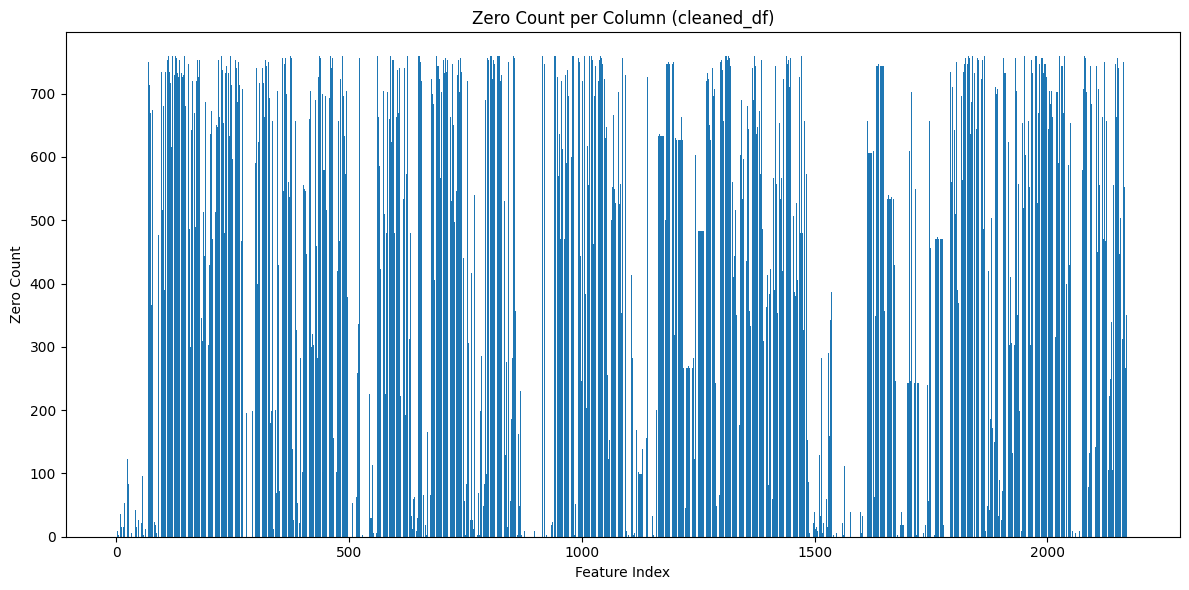

      index                                        column  zero_count
0         0                                          YEAR           0
1         1                            AGLAND_AGLANDACRES           9
2         2               AGLAND_AGLANDCROPINSURANCEACRES           9
3         3  AGLAND_AGLANDCROPINSURANCENUMBEROFOPERATIONS           0
4         4                    AGLAND_AGLANDCROPLANDACRES           3
...     ...                                           ...         ...
2172   2172       WHEAT_WHEATWINTERPRODUCTIONMEASUREDINBU         270
2173   2173             WOOL_WOOLOPERATIONSWITHPRODUCTION          96
2174   2174               WOOL_WOOLPRODUCTIONMEASUREDINLB         243
2175   2175                      WOOL_WOOLSALESMEASUREDIN         609
2176   2176                                   COUNTY_NAME           0

[2177 rows x 3 columns]


In [8]:

# --- Zero counts ---
# Compute zero counts
zero_counts = (cleaned_df == 0).sum()

# Use numeric indices instead of long labels
x = range(len(zero_counts))

plt.figure(figsize=(12,6))
plt.bar(x, zero_counts.values)
plt.title("Zero Count per Column (cleaned_df)")
plt.xlabel("Feature Index")
plt.ylabel("Zero Count")
plt.tight_layout()
plt.show()

#print index -> column lookup
lookup = pd.DataFrame({
    "index": x,
    "column": zero_counts.index,
    "zero_count": zero_counts.values
})
print(lookup)


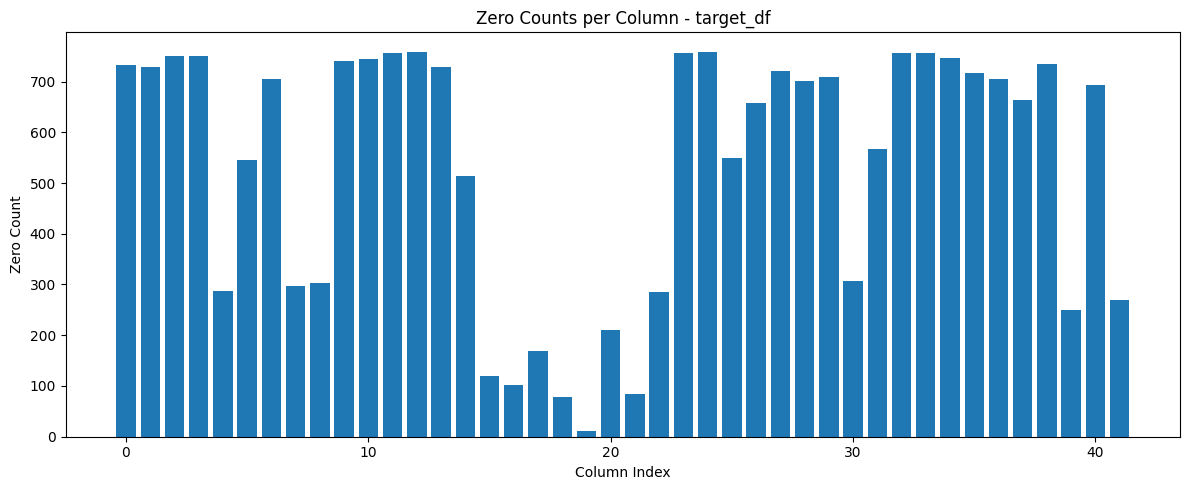

In [9]:
#get target crops from txt file
with open("models/croptarget.txt") as f:
    crops = [line.strip() for line in f.readlines() if line.strip()]


#find columns based on <crop> _ PRODUCTION for target df
target_cols = [
    col for col in cleaned_df.columns
    if col.split("_")[0] in crops and "PRODUCTION" in col.upper()
]

target_df = cleaned_df[target_cols]

#get zero counts
zero_counts_target = (target_df == 0).sum()

plt.figure(figsize=(12, 5))
plt.bar(range(len(zero_counts_target)), zero_counts_target.values)
plt.xlabel("Column Index")
plt.ylabel("Zero Count")
plt.title("Zero Counts per Column - target_df")
plt.tight_layout()
plt.show()


In [10]:
print(target_df.columns[19])

HAY_HAYPRODUCTIONMEASUREDINTONS


### Insights gained from EDA that inform next steps.

A better target for us is production of crops. The yield of a crop is derived from the amount of production so the impact of the models will stay the same. Additionally every county is required to report production for each good that they produce meaning that we will have plenty of options/crops to choose to design our model off of. Furthermore, if we need more samples for our models the possibility of expanding to nearby states has been considered since many southern states grow similar crops.

The general takeaway is that most of the data that we have at least for our targets crops. Most farms don't grow every crop so most models will not work unless a very large amount of samples for each crop is present. For our specific crop, the best to use would be hay since only 12 samples are 0 meaning only 4 counties in Texas do not grow hay. We decided hay is the best crop to build our models with this data.


# Methodology

## Baseline method implementation

##### The two baseline models that we are using are Random Forest Regression and Linear Regression

# Data Handling and Prep

In [2]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import numpy as np
import os

#helps resolve path problems
base = os.getcwd()

filepath =  os.path.join(base, "data/cleaned_COUNTY_data.csv")

cleaned_df = pd.DataFrame(pd.read_csv(filepath))

In [4]:
#get target crops from txt file
with open("models/croptarget.txt") as f:
    crops = [line.strip() for line in f.readlines() if line.strip()]

print(crops)

['BARLEY', 'BEANS', 'BEETS', 'CANOLA', 'CORN', 'COTTON', 'GRAIN', 'GRASSES', 'GRASSES & LEGUMES, OTHER', 'GUAR', 'HAY', 'HAY & HAYLAGE', 'HAYLAGE', 'MILLET', 'MINT', 'MISCANTHUS', 'MUSTARD', 'OATS', 'PEANUTS', 'POPcorn', 'RICE', 'RYE', 'SAFFLOWER', 'SESAME', 'SORGHUM', 'SUGARCANE', 'SUNFLOWER', 'TRITICALE', 'WHEAT']


In [5]:
#NaN values for unreported numbers from farms
cleaned_df = cleaned_df.fillna(0)
cleaned_df.drop("Unnamed: 0",axis=1,inplace=True)
cleaned_df

,YEAR,AGLAND_AGLANDACRES,AGLAND_AGLANDCROPINSURANCEACRES,AGLAND_AGLANDCROPINSURANCENUMBEROFOPERATIONS,AGLAND_AGLANDCROPLANDACRES,AGLAND_AGLANDCROPLANDAREAMEASUREDINPCTOFAGLAND,AGLAND_AGLANDCROPLANDEXCLHARVESTEDPASTUREDACRES,AGLAND_AGLANDCROPLANDEXCLHARVESTEDPASTUREDALLCROPSFAILEDACRES,AGLAND_AGLANDCROPLANDEXCLHARVESTEDPASTUREDALLCROPSFAILEDNUMBEROFOPERATIONS,AGLAND_AGLANDCROPLANDEXCLHARVESTEDPASTUREDCULTIVATEDSUMMERFALLOWACRES,...,WHEAT_WHEATSPRINGEXCLDURUMPRODUCTIONMEASUREDINBU,WHEAT_WHEATWINTERACRESHARVESTED,WHEAT_WHEATWINTERIRRIGATEDACRESHARVESTED,WHEAT_WHEATWINTERIRRIGATEDOPERATIONSWITHAREAHARVESTED,WHEAT_WHEATWINTEROPERATIONSWITHAREAHARVESTED,WHEAT_WHEATWINTERPRODUCTIONMEASUREDINBU,WOOL_WOOLOPERATIONSWITHPRODUCTION,WOOL_WOOLPRODUCTIONMEASUREDINLB,WOOL_WOOLSALESMEASUREDIN,COUNTY_NAME
0,2012,7391.0,10512.0,32.0,70333.0,13.75,4862.0,3134.0,85.0,858.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,ANDERSON
1,2017,32795.0,14907.0,14.0,63774.0,13.75,4239.5,1979.0,59.0,2112.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,ANDERSON
2,2022,32469.0,16196.0,41.0,69021.0,13.75,5632.0,2740.0,103.0,3542.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,ANDERSON
3,2012,24662.0,23915.0,19.0,71517.0,8.00,29342.5,9247.0,26.0,7806.0,...,0.0,1500.0,320.0,2.0,2.0,31400.0,1.0,2250.0,0.0,ANDREWS
4,2017,32830.0,322066.0,12.0,78257.0,8.00,35201.5,9247.0,12.0,7806.0,...,0.0,1500.0,320.0,4.0,7.0,31400.0,2.0,2250.0,0.0,ANDREWS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,2017,15203.0,21736.0,21.0,18856.0,6.50,12208.0,247.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,ZAPATA
758,2022,4025.0,23413.0,17.0,5980.0,6.50,1897.5,247.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,ZAPATA
759,2012,295056.0,50198.0,39.0,95980.0,9.50,11980.5,4298.0,27.0,4936.0,...,0.0,3978.0,2206.0,10.0,23.0,247228.0,1.0,0.0,0.0,ZAVALA
760,2017,401018.0,57149.0,39.0,76046.0,9.50,15045.0,1731.0,12.0,10893.0,...,0.0,3978.0,2206.0,13.0,19.0,247228.0,1.0,0.0,0.0,ZAVALA


In [6]:
#find columns based on <crop> _ PRODUCTION for target df
target_cols = [
    col for col in cleaned_df.columns
    if col.split("_")[0] in crops and "PRODUCTION" in col.upper()
]

target_df = cleaned_df[target_cols]

In [7]:
#from EDA we found Hay to have the most usable data at index 19
target_hay = target_df['HAY_HAYPRODUCTIONMEASUREDINTONS']

target_hay

0       93093.0
1       92932.0
2      103167.0
3        1877.0
4         795.0
         ...   
757      1066.0
758       882.0
759      9089.0
760     20933.0
761     19441.0
Name: HAY_HAYPRODUCTIONMEASUREDINTONS, Length: 762, dtype: float64

In [8]:
leakage_patterns = ["PRODUCTION", "HARVESTED", "HARVEST", "YIELD"]

mask = ~cleaned_df.columns.str.contains("|".join(leakage_patterns), case=False)

X_clean = cleaned_df.loc[:, mask]

In [9]:
X_clean.shape

(762, 1456)

In [10]:
#prep for tensorflow
X = X_clean.drop(X_clean.columns[[0,1454]], axis=1, errors="ignore")
y = target_hay

X = X.apply(pd.to_numeric, errors="coerce")

X

,AGLAND_AGLANDACRES,AGLAND_AGLANDCROPINSURANCEACRES,AGLAND_AGLANDCROPINSURANCENUMBEROFOPERATIONS,AGLAND_AGLANDCROPLANDACRES,AGLAND_AGLANDCROPLANDAREAMEASUREDINPCTOFAGLAND,AGLAND_AGLANDCROPLANDEXCLPASTUREDOPERATIONSWITHTREATED,AGLAND_AGLANDCROPLANDEXCLPASTUREDTREATEDMEASUREDINACRES,AGLAND_AGLANDCROPLANDNUMBEROFOPERATIONS,AGLAND_AGLANDCROPLANDPASTUREDONLYACRES,AGLAND_AGLANDCROPLANDPASTUREDONLYNUMBEROFOPERATIONS,...,WALNUTS_WALNUTSENGLISHACRESBEARING,WALNUTS_WALNUTSENGLISHACRESBEARINGNONBEARING,WALNUTS_WALNUTSENGLISHACRESNONBEARING,WALNUTS_WALNUTSENGLISHOPERATIONSWITHAREABEARING,WALNUTS_WALNUTSENGLISHOPERATIONSWITHAREABEARINGNONBEARING,WALNUTS_WALNUTSENGLISHOPERATIONSWITHAREANONBEARING,WATER_WATERIRRIGATIONSOURCEOFFFARMSUPPLIERFEDERALBUREAUOFRECLAMATIONOPERATIONSWITHWATERRECEIVED,WHEAT_WHEATOPERATIONSWITHSALES,WHEAT_WHEATSALESMEASUREDIN,COUNTY_NAME
0,7391.0,10512.0,32.0,70333.0,13.75,349.0,16018.0,1252.0,6300.0,113.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,NaN
1,32795.0,14907.0,14.0,63774.0,13.75,335.0,21529.0,1098.0,3018.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,NaN
2,32469.0,16196.0,41.0,69021.0,13.75,341.0,19072.0,1041.0,6817.0,106.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,NaN
3,24662.0,23915.0,19.0,71517.0,8.00,28.0,11196.0,113.0,3163.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,NaN
4,32830.0,322066.0,12.0,78257.0,8.00,30.0,13780.0,81.0,3163.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,15203.0,21736.0,21.0,18856.0,6.50,8.0,1275.0,52.0,3105.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN
758,4025.0,23413.0,17.0,5980.0,6.50,3.0,1507.5,36.0,1953.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN
759,295056.0,50198.0,39.0,95980.0,9.50,48.0,27759.0,118.0,42662.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,1655000.0,NaN
760,401018.0,57149.0,39.0,76046.0,9.50,38.0,34367.0,121.0,17766.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,1044000.0,NaN


In [11]:
corr_matrix = pd.DataFrame(X).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop them
X_reduced = X.drop(columns=to_drop)
print("Dropped highly correlated features:", len(to_drop))

Dropped highly correlated features: 495


In [12]:
y.shape

(762,)

In [13]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Step 1: Use the correlation-cleaned feature matrix
X_corrclean = X_reduced   # (after leakage removal + correlation filtering)

# Step 2: Initialize importance vector with correct length
importances = np.zeros(X_corrclean.shape[1])

# Step 3: Loop over each production target (each crop)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_corrclean, y.iloc[:,])
importances += rf.feature_importances_

# Step 4: Select top 200 most important features
top_idx = np.argsort(importances)[-200:]

# Step 6: Reduce dataset
X_reduced = X_corrclean.iloc[:, top_idx]

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)


In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
X_pca = pca.fit_transform(X_scaled)


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

# Random Forest Regressor

RF Regression Performance:
MAE: 11844.966797385621
RMSE: 19176.63297885058
R²: 0.7200705188271962


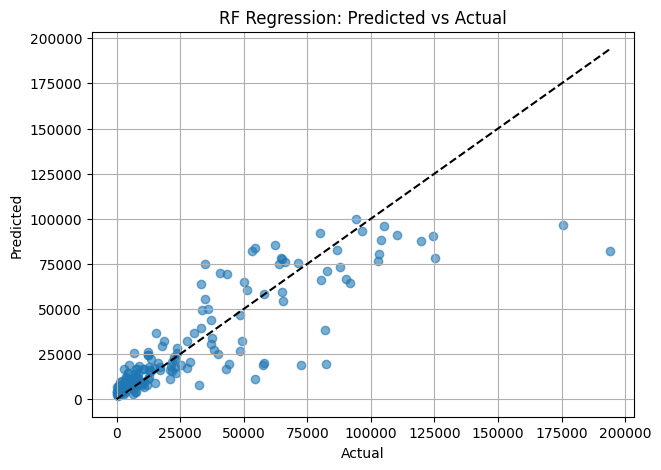

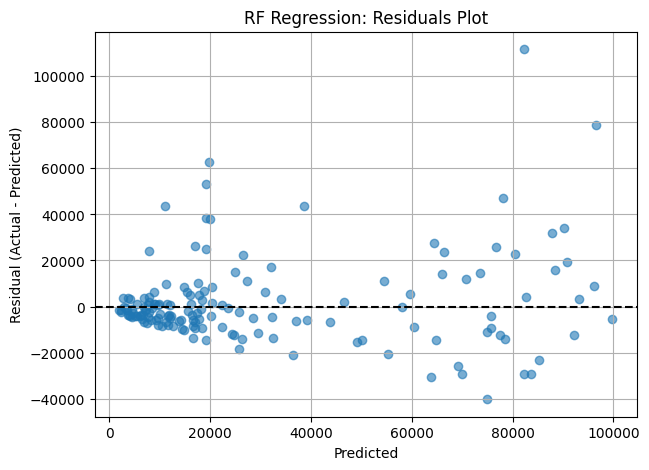

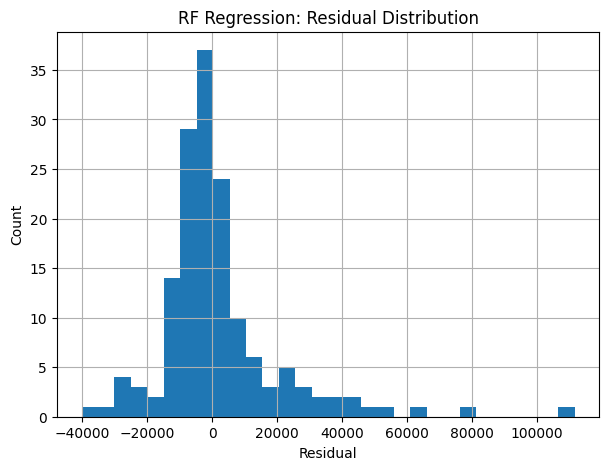

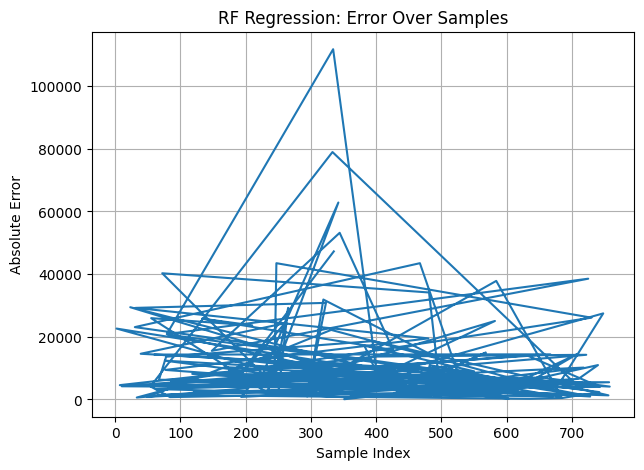

In [17]:
#This score is a lot better than when trying to predict production for all 42 crops
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt

rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_lr = rf.predict(X_val)

# Compute metrics
mae = mean_absolute_error(y_val, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_lr))
r2 = r2_score(y_val, y_pred_lr)

print("RF Regression Performance:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

# ------------------------------
# 1. Predicted vs. Actual
# ------------------------------
plt.figure(figsize=(7,5))
plt.scatter(y_val, y_pred_lr, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("RF Regression: Predicted vs Actual")
plt.grid(True)
plt.show()

# ------------------------------
# 2. Residuals vs Predicted
# ------------------------------
residuals = y_val - y_pred_lr

plt.figure(figsize=(7,5))
plt.scatter(y_pred_lr, residuals, alpha=0.6)
plt.axhline(0, linestyle='--', color='black')
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("RF Regression: Residuals Plot")
plt.grid(True)
plt.show()

# ------------------------------
# 3. Residual Distribution
# ------------------------------
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=30)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("RF Regression: Residual Distribution")
plt.grid(True)
plt.show()

# ------------------------------
# 4. Error Over Samples
# ------------------------------
plt.figure(figsize=(7,5))
plt.plot(np.abs(residuals))
plt.xlabel("Sample Index")
plt.ylabel("Absolute Error")
plt.title("RF Regression: Error Over Samples")
plt.grid(True)
plt.show()

## Results

RF Regression Performance:
- MAE: 11844.966797385621
- RMSE: 19176.63297885058
- R²: 0.7200705188271962

## Insights on RF Regressor

The model performed decently well, the cluster at the low production values shows that the model performs better for smaller farms. There is a possible higher variance in data for larger farms. We can also see from the residuals count graph that there are fewer large farms. Only 3 farms produce greater than 60,000 tons of hay. 

# Linear Regression

Linear Regression Performance:
MAE: 9056.647045698111
RMSE: 13209.745167371735
R²: 0.8671710297901866


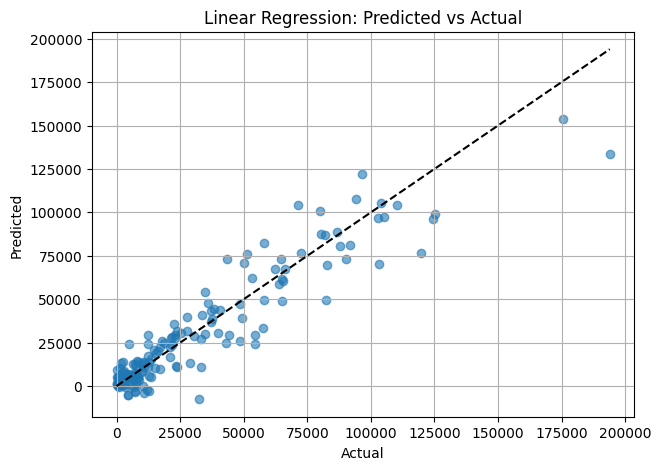

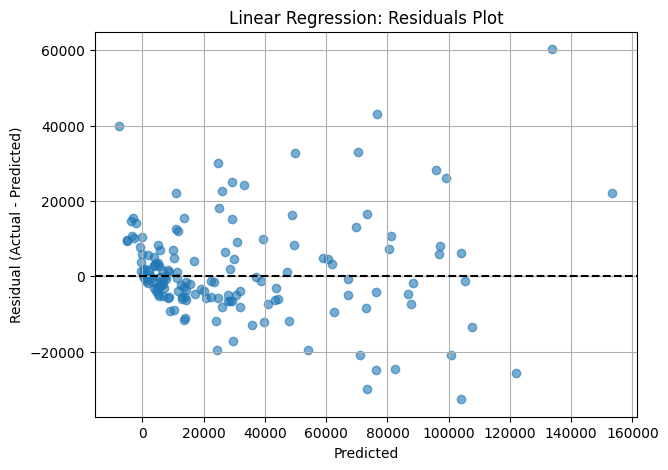

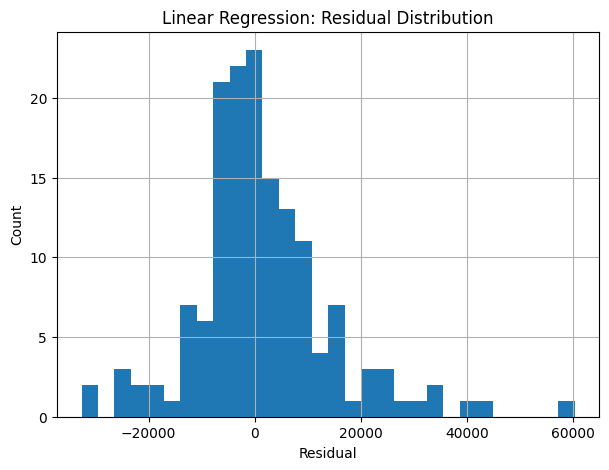

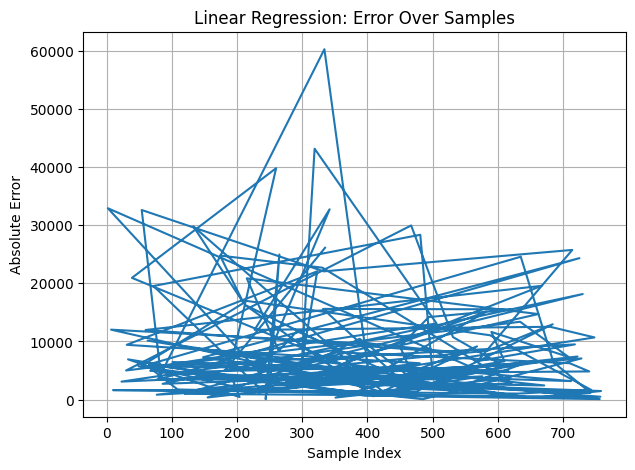

In [ ]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lr = linreg.predict(X_val)

# Compute metrics
mae = mean_absolute_error(y_val, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_lr))
r2 = r2_score(y_val, y_pred_lr)

print("Linear Regression Performance:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

# ------------------------------
# 1. Predicted vs. Actual
# ------------------------------
plt.figure(figsize=(7,5))
plt.scatter(y_val, y_pred_lr, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression: Predicted vs Actual")
plt.grid(True)
plt.show()

# ------------------------------
# 2. Residuals vs Predicted
# ------------------------------
residuals = y_val - y_pred_lr

plt.figure(figsize=(7,5))
plt.scatter(y_pred_lr, residuals, alpha=0.6)
plt.axhline(0, linestyle='--', color='black')
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Linear Regression: Residuals Plot")
plt.grid(True)
plt.show()

# ------------------------------
# 3. Residual Distribution
# ------------------------------
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=30)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Linear Regression: Residual Distribution")
plt.grid(True)
plt.show()

# ------------------------------
# 4. Error Over Samples 
# ------------------------------
plt.figure(figsize=(7,5))
plt.plot(np.abs(residuals))
plt.xlabel("Sample Index")
plt.ylabel("Absolute Error")
plt.title("Linear Regression: Error Over Samples")
plt.grid(True)
plt.show()


## Results

Linear Regression Performance:
- MAE: 9056.647045698111
- RMSE: 13209.745167371735
- R²: 0.8671710297901866

## Insights on RF Regressor

This model performs similarly to the RF regressor. The residuals are more spread than the RF at the low end but is more consistent throughout. Additionally, the LR handled the two outlier cases better as well. The LR model may be able to take advantage of linear natures of farming. For example more fertilizer may allow for more crops to receive more fertilizer overall. The LR model also more closely resembles our improved model.

## Discussion of Results

Comparing the two baseline models we can conclude the LR model performs better than the RF Regressor model. From observing the improved model and taking in consideration of the end size of our cleaned data. The RF Regressor model is most likely overfitting our data, meaning the simplicity of the LR model greatly benefits it's performance.

## Improvements and other methods implementation

*Feature engineering, feature selection, and high dimensionality mitigation.*

The feature engineering, feature selection and high dimensionality mitigation that we are using boils down to three different processes: Correlation filtering, RF regressor and PCA

Before, we managed leakage first for the model removing any columns that may have had our targets or overly correlated data in it to prevent overfitting.

| Concept                     | Correlation Filtering                                              | Random Forest Regressor                                            | PCA                                                                  |
|-----------------------------|--------------------------------------------------------------------|---------------------------------------------------------------------|----------------------------------------------------------------------|
| **Feature Engineering**     | Builds cleaner relationships that correlations can detect          | Gives RF clearer nonlinear patterns to learn                       | Produces more meaningful variance directions for PCA                |
| **Feature Selection**       | Removes weak or redundant features using correlation thresholds    | Uses RF feature importance to keep only top predictors              | Removes noise so PCA learns from high-quality inputs                |
| **High-Dimensionality Mitigation** | Quickly eliminates redundant or low-signal features in large datasets | Prevents RF from splitting on noise or overfitting in high-dim data | PCA directly reduces dimensionality into dense, informative components |



The improved model that we are using over our baseline is a shallow neural network. 
The benefits of using a NN over mean predictor and linear regression is present in handling colinearity and high dimensionality better.
There are a few risks since our transformed data is not huge NN have a higher risk of overfitting additionally they take longer to train and are uninterperatable.

For current implementation we will include the code for the feature selection and the model for the NN currently. 

A few issues have been primarily rooted from the development of the improved model, mainly the broadness of our goal. The 42 targets is too much for the shallow NN and we don't have enough data to for convergence.
A focused crop like hay will be persued and trained. Once again, if more data is needed. We will expand our regions to adjacent states counties including Texas.



### Correlation filtering
```py
corr_matrix = pd.DataFrame(X).corr().abs()

#Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

#find features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

#Drop them
X_reduced = X.drop(columns=to_drop)
print("Dropped highly correlated features:", len(to_drop))

# RF Regressor
```python
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Step 1: Use the correlation-cleaned feature matrix
X_corrclean = X_reduced   # (after leakage removal + correlation filtering)

# Step 2: Initialize importance vector with correct length
importances = np.zeros(X_corrclean.shape[1])

# Step 3: Loop over each production target (each crop)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_corrclean, y.iloc[:,])
importances += rf.feature_importances_

# Step 4: Select top 200 most important features
top_idx = np.argsort(importances)[-200:]

# Step 6: Reduce dataset
X_reduced = X_corrclean.iloc[:, top_idx]
```



# PCA
```python
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)


from sklearn.decomposition import PCA

pca = PCA(n_components=200)
X_pca = pca.fit_transform(X_scaled)

```
*Note: scale/normalize values before pca is required*


# Shallow NN Model

```python
#input_dim = (609,200) #X_train
#output_dim = (609,)   #y_train



model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="relu", input_shape=(200,),kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(128, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(1)  #single output for hay production
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

#if loss is too low(model not learning) stop
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

#reduce learnrate/step size through training to help model learn more patterns
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=20, min_lr=1e-5
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[reduce_lr],
    verbose=2
)

# Metrics Gathering

```python
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()
```
*Note: Does not show full epoch range. Platau occurs around 300 epochs*

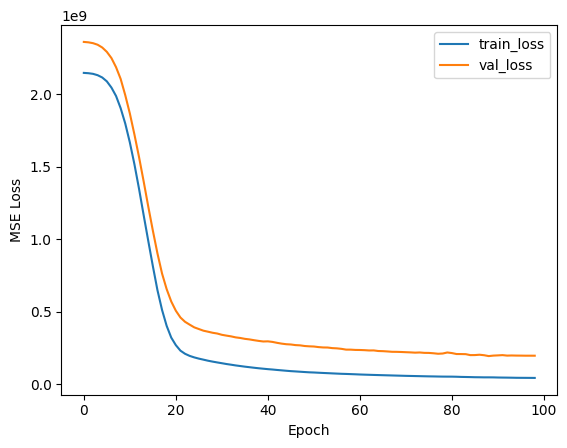
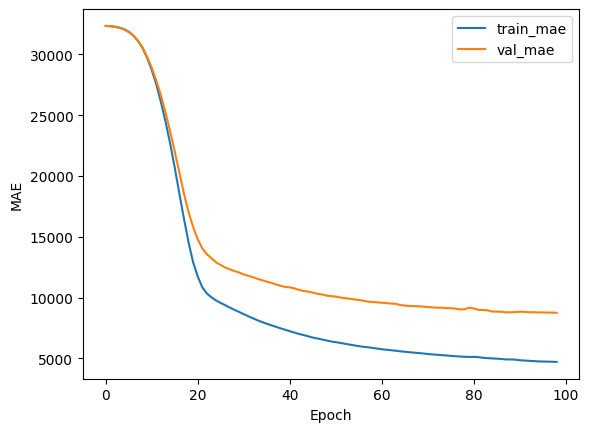

```py
y_pred = model.predict(X_val).flatten()  

plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         linestyle='--')

plt.xlabel("Actual Hay Yield")
plt.ylabel("Predicted Hay Yield")
plt.title("Predicted vs Actual (Validation)")
plt.show()
```

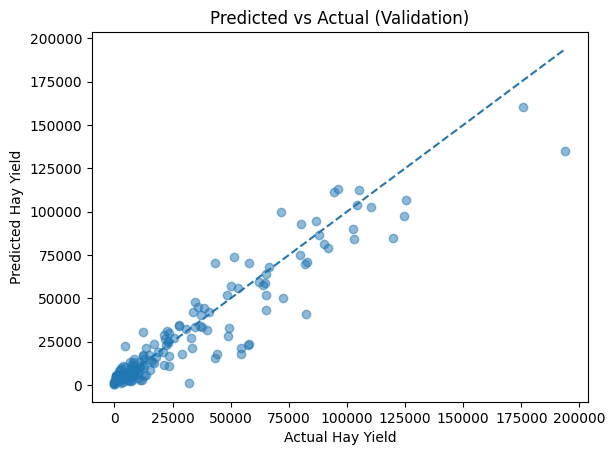

```py
residuals = y_val - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals Plot")
plt.show()
```

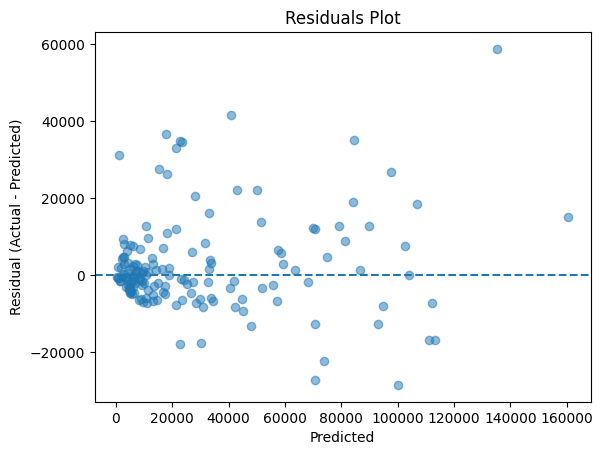

## Short Analysis

- The Mean of the target value "HAYPRODUCTIONINTONS" = 93,093
- MAE of the model was consistant around 8000-8200
- Relative error: ~8.7%-9.0%

### What This means:

- The model has a good prediction on hay production since crops are a highly variable due to many different factors influencing their growth

### Key Insight:

- The model performs very well for smaller farms and production values.
- The model follows the diagonal trend well meaning the relationships were captured
- Little to no bias in the model, points are evenely distributed on sides of the regression line
- Modeel still overfits, expected of this NN and size of data

### Future of improvement model

- Explain why the model decreases in accuracy for larger production numbers
- Explain process of hyper paramater tuning and model generation steps

## Last week goals:
- Stephen: work on improved model on a more specific target
- Shaz: working the baseline models.

## Teaming Strategy

Communicate through discord and meet once a week

## Individual team member contributions.

- Stephen Cox, Improvement model and data handling, EDA
- Shaz Momin, completed baseline models.


## Mitigation Plan

We will drop one of the models and do a deeper analysis

## Key milestones or tasks to be completed by project end.

Finish models, analyze models. Make presentation and final report.

## Who is responsible for each task?

- Stephen: improvement model
- Shaz: Baseline model
- Prabesh: analysis of models, bulk of presentation

All: presentation and final report

### Timeline/checkpoints to ensure on-time submission.

Models finished by Tuesday, presentation with some analysis wednesday and thursday morning. Final tuning and report before deadline.


## What if you fail?

- Baseline: more specific target as a backup
- group work: submit what we have. finish as much as possible